## Pneumonia Detection on Chest X-Rays with Deep Learning

The dataset comes from this [paper](https://arxiv.org/pdf/1711.05225.pdf)

Also, implementing this [paper] (https://arxiv.org/pdf/1610.02391.pdf)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from datetime import datetime
import cv2
from collections import OrderedDict

In [2]:
import os
from tqdm import tqdm_notebook as tqdm

In [3]:
PATH = Path("/data2/yinterian/ChestXray/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/ChestXray/images'),
 PosixPath('/data2/yinterian/ChestXray/val_df.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_250'),
 PosixPath('/data2/yinterian/ChestXray/test_df.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_010.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_001.zip'),
 PosixPath('/data2/yinterian/ChestXray/README_CHESTXRAY.pdf'),
 PosixPath('/data2/yinterian/ChestXray/test_list.txt'),
 PosixPath('/data2/yinterian/ChestXray/ARXIV_V5_CHESTXRAY.pdf'),
 PosixPath('/data2/yinterian/ChestXray/images_011.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_004.zip'),
 PosixPath('/data2/yinterian/ChestXray/BBox_List_2017.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_007.zip'),
 PosixPath('/data2/yinterian/ChestXray/Data_Entry_2017.csv'),
 PosixPath('/data2/yinterian/ChestXray/images_002.zip'),
 PosixPath('/data2/yinterian/ChestXray/images_008.zip'),
 PosixPath('/data2/yinterian/ChestXray/val_Pneumonia_df.csv'),
 PosixPath('/data2/yin

## Preprocessing 

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
images_paths = list((PATH/"images").iterdir())

In [6]:
images_paths[:10]

[PosixPath('/data2/yinterian/ChestXray/images/00021341_016.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00011460_012.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00005311_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00021120_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00029431_003.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00027564_002.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00006271_096.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00004461_014.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00020917_000.png'),
 PosixPath('/data2/yinterian/ChestXray/images/00012402_000.png')]

## Random transforms

In [7]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x):
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [8]:
def norm_for_imageNet(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (img - imagenet_stats[0])/imagenet_stats[1]

In [9]:
def apply_transforms(x):
    """ Applies a random crop, rotation"""
    rdeg = (np.random.random()-.50)*20
    x = rotate_cv(x, rdeg)
    if np.random.random() > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x)
    return x

class ChestXrayDataSet(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        self.image_files = df["ImageIndex"].values
        self.labels = df["Label"].values
        self.transform = transform
        self.image_path = PATH/"images_250"

    def __getitem__(self, index):
        path = self.image_path/self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transform:
            x = apply_transforms(x)
        else:
            x = center_crop(x)
            
        x = norm_for_imageNet(x)
        y = np.array([int(i) for i in self.labels[index].split(" ")]).astype(np.float32)
        return np.rollaxis(x, 2), y

    def __len__(self):
        return len(self.image_files)

In [10]:
train_df = pd.read_csv(PATH/"train_df.csv")
val_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

In [11]:
val_df.shape, train_df.shape, test_df.shape

((9069, 2), (77455, 2), (25596, 2))

In [12]:
batch_size = 16
train_ds = ChestXrayDataSet(train_df, transform=True)
valid_ds = ChestXrayDataSet(val_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=1)

## Model 

First install the efficientnet-pytorch package on your command line:
`pip install efficientnet-pytorch`

In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
class EfficientNet4(nn.Module):
    def __init__(self, out_size=14):
        super(EfficientNet4, self).__init__()
        effnet = EfficientNet.from_pretrained('efficientnet-b4')
        layers = list(effnet.children())
        K = len(layers[2])//2
        h1 = layers[:2] + list(layers[2])[:K]
        h2 = list(layers[2])[K:] + layers[3:5]
        self.features1 = nn.Sequential(*h1)
        self.features2 = nn.Sequential(*h2)
        self.classifier = nn.Sequential(*[nn.Linear(1792, out_size)])

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        return self.classifier(x)

In [15]:
model = EfficientNet4().cuda()

Loaded pretrained weights for efficientnet-b4


In [16]:
x,y = next(iter(train_dl))
x = x.float().cuda()
y = y.float().cuda()

In [17]:
pred = model(x)
F.binary_cross_entropy_with_logits(pred, y).item()

0.8039469122886658

## Metrics

In [16]:
def ave_auc(probs, ys):
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    aucs = [metrics.roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(aucs), aucs

In [17]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    mean_auc, _ = ave_auc(probs, ys)
    return sum_loss/total, mean_auc

In [17]:
#val_metric(model, valid_dl)

## Training functions

In [18]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

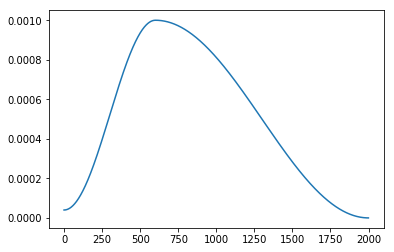

In [19]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [20]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [21]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            pbar.update()
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_auc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_auc %.3f \n" % 
              (train_loss, val_loss, val_auc))
        if val_auc > prev_val_auc:
            prev_val_auc = val_auc
            path = "{0}/models/model_efficient_net_0_auc_{1:.0f}.pth".format(PATH, 100*val_auc) 
            save_model(model, path)
            print(path)
    return sum_loss/total

In [22]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            pbar.update()
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [24]:
model = EfficientNet4().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_high=0.01)

Loaded pretrained weights for efficientnet-b4


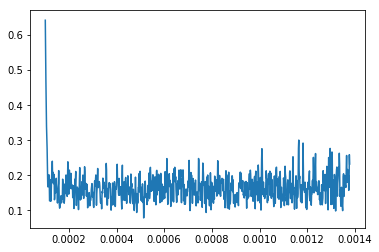

In [26]:
plt.plot(lrs[:1000], losses[:1000])
plt.show()

## Run Training

In [ ]:
#model = EfficientNet4().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0005, epochs = 10)

train_loss 0.152 val_loss 0.151 val_auc 0.768 

/data2/yinterian/ChestXray/models/model_efficient_net_0_auc_77.pth


In [22]:
model = EfficientNet0().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0005, epochs = 10)

Loaded pretrained weights for efficientnet-b0


train_loss 0.163 val_loss 0.156 val_auc 0.749 

/data2/yinterian/ChestXray/models/model_densenet_auc_75.pth
train_loss 0.143 val_loss 0.149 val_auc 0.792 

/data2/yinterian/ChestXray/models/model_densenet_auc_79.pth
train_loss 0.140 val_loss 0.152 val_auc 0.780 

train_loss 0.136 val_loss 0.145 val_auc 0.807 

/data2/yinterian/ChestXray/models/model_densenet_auc_81.pth
train_loss 0.130 val_loss 0.150 val_auc 0.805 

train_loss 0.122 val_loss 0.151 val_auc 0.801 

train_loss 0.113 val_loss 0.155 val_auc 0.794 

train_loss 0.103 val_loss 0.162 val_auc 0.786 

train_loss 0.094 val_loss 0.166 val_auc 0.784 

train_loss 0.090 val_loss 0.169 val_auc 0.782 



0.08991800237791632

In [ ]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0005, epochs = 10)

In [52]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.002, epochs = 8)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


train_loss 0.149 val_loss 0.151 val_auc 0.778 

/data2/yinterian/ChestXray/models/model_densenet_auc_78.pth
train_loss 0.143 val_loss 0.149 val_auc 0.774 

train_loss 0.141 val_loss 0.145 val_auc 0.796 

/data2/yinterian/ChestXray/models/model_densenet_auc_80.pth
train_loss 0.137 val_loss 0.154 val_auc 0.789 

train_loss 0.133 val_loss 0.143 val_auc 0.822 

/data2/yinterian/ChestXray/models/model_densenet_auc_82.pth
train_loss 0.129 val_loss 0.139 val_auc 0.832 

/data2/yinterian/ChestXray/models/model_densenet_auc_83.pth
train_loss 0.125 val_loss 0.138 val_auc 0.835 

/data2/yinterian/ChestXray/models/model_densenet_auc_84.pth
train_loss 0.122 val_loss 0.138 val_auc 0.836 

/data2/yinterian/ChestXray/models/model_densenet_auc_84.pth


0.12215074791270163

In [46]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs = 8)

train_loss 0.154 val_loss 0.145 val_auc 0.784 

/data2/yinterian/ChestXray/models/model_densenet_auc_78.pth
train_loss 0.140 val_loss 0.147 val_auc 0.796 

/data2/yinterian/ChestXray/models/model_densenet_auc_80.pth
train_loss 0.138 val_loss 0.143 val_auc 0.814 

/data2/yinterian/ChestXray/models/model_densenet_auc_81.pth
train_loss 0.134 val_loss 0.147 val_auc 0.816 

/data2/yinterian/ChestXray/models/model_densenet_auc_82.pth
train_loss 0.130 val_loss 0.141 val_auc 0.825 

/data2/yinterian/ChestXray/models/model_densenet_auc_83.pth
train_loss 0.125 val_loss 0.137 val_auc 0.837 

/data2/yinterian/ChestXray/models/model_densenet_auc_84.pth
train_loss 0.121 val_loss 0.137 val_auc 0.842 

/data2/yinterian/ChestXray/models/model_densenet_auc_84.pth
train_loss 0.118 val_loss 0.138 val_auc 0.843 

/data2/yinterian/ChestXray/models/model_densenet_auc_84.pth


0.1179544258526301

In [48]:
test_ds = ChestXrayDataSet(test_df)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=1)

In [49]:
val_metric(model, test_dl)

(0.2018303742257063, 0.8175582607440202)

## val metrics with aucs

In [102]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    mean_auc, aucs = ave_auc(probs, ys)
    return sum_loss/total, mean_auc, aucs

In [103]:
val_loss, val_mean_auc, aucs = val_metric(model, valid_dl)

In [104]:
val_mean_auc

0.8625853675970793

In [105]:
aucs

[0.8256200575125807,
 0.9325535257328605,
 0.8701481384138232,
 0.7294233703935785,
 0.8852881088226712,
 0.8260630285101249,
 0.7948964981847089,
 0.9146713480790198,
 0.8015501062714462,
 0.8959595952812058,
 0.9359654734578096,
 0.8686472667375862,
 0.8357169813415025,
 0.9596916476201933]

## Layer names for densenet121

In [181]:
#for m in model.named_modules():
#    print("\t", m[0])

## Grad Cam

In [159]:
class GradCAM(object):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__()
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(module, input, output):
            # Save featuremaps
            self.fmap_pool[id(module)] = output.detach()

        def backward_hook(module, grad_in, grad_out):
            # Save the gradients correspond to the featuremaps
            self.grad_pool[id(module)] = grad_out[0].detach()

        # If any candidates are not specified, the hook is registered to all the layers.
        for module in self.model.named_modules():
            if self.candidate_layers is None or module[0] in self.candidate_layers:
                self.handlers.append(module[1].register_forward_hook(forward_hook))
                self.handlers.append(module[1].register_backward_hook(backward_hook))
                
    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).cuda()
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def _find(self, pool, target_layer):
        for key, value in pool.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)
    
    def forward(self, image):
        """
        multi-label classification
        """
        self.image_shape = image.shape[2:]
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.sigmoid(self.logits)
        return self.probs.sort(dim=1, descending=True)
    
    def backward(self, one_hot):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        #one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)
        return gcam
    
    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

In [182]:
def preprocess(image_path):
    raw_image = cv2.imread(str(image_path)).astype(np.float32)
    x = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)/255
    x = center_crop(x)
    x = norm_for_imageNet(x)
    x = np.rollaxis(x, 2)
    x = torch.FloatTensor(x)
    return x, center_crop(raw_image)

In [183]:
def preprocess_all(image_paths):
    images = []
    raw_images = []
    for i, image_path in enumerate(image_paths):
        print("\t#{}: {}".format(i, image_path))
        image, raw_image = preprocess(image_path)
        images.append(image)
        raw_images.append(raw_image)
    images = torch.stack(images).cuda()
    return images, raw_images

In [184]:
def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))

In [185]:
def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))

In [354]:
i = 160
f = val_df["ImageIndex"].values[i]
y = val_df["Label"].values[i]
y = np.array([int(i) for i in y.split(" ")]).astype(np.float32)
y = torch.FloatTensor(y)
path = PATH/"images_250"/f
path, y

(PosixPath('/data2/yinterian/ChestXray/images_250/00000211_010.png'),
 tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

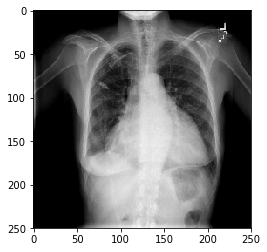

In [355]:
im = cv2.imread(str(path))
plt.imshow(im, cmap='gray')

In [356]:
images, raw_images =  preprocess_all([path])

	#0: /data2/yinterian/ChestXray/images_250/00000211_010.png


In [357]:
target_layer = "densenet121.features.denseblock4.denselayer16.conv2"
gcam = GradCAM(model=model)

In [358]:
gcam.forward(images)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(tensor([[8.3432e-01, 5.5392e-01, 3.3794e-01, 9.0001e-02, 7.9305e-02, 6.0741e-02,
          2.1458e-02, 2.0180e-02, 1.9203e-02, 1.8042e-02, 1.3299e-02, 9.8772e-03,
          3.4899e-03, 1.2728e-04]], device='cuda:0', grad_fn=<SortBackward>),
 tensor([[ 1,  2,  3,  9,  0, 12, 11,  5,  6,  8,  7,  4, 10, 13]],
        device='cuda:0'))

In [359]:
y[None].shape

torch.Size([1, 14])

In [360]:
gcam.backward(y[None].cuda())

In [361]:
regions = gcam.generate(target_layer=target_layer)
reg = regions[0,0]
reg = reg.cpu().numpy()

In [363]:
reg.shape

(234, 234)

In [364]:
import matplotlib.cm as cm
cmap = cm.jet(reg)[..., :3] * 255.0

In [365]:
cmap.shape

(234, 234, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


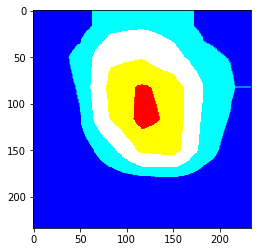

In [366]:
plt.imshow(cmap)

In [367]:
raw_image = raw_images[0]
g_cam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2

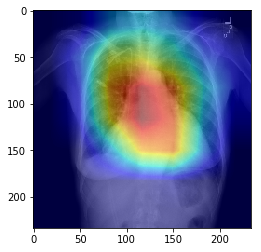

In [368]:
plt.imshow(g_cam/255)

## Clustering

In [351]:
p1 = np.percentile(img, 40)
p2 = np.percentile(img, 85)
print(p1, p2)
markers[img < p1] = 1
markers[img > p1] = 2
markers[img > p2] = 3

152.0 204.0


In [352]:
segmentation = watershed(elevation_map, markers)

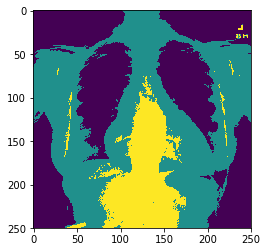

In [349]:
plt.imshow(segmentation)

In [299]:
elevation_map

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08923723, 0.00903877, ..., 0.0254902 , 0.02634319,
        0.        ],
       [0.        , 0.01082879, 0.00490196, ..., 0.02203157, 0.02120913,
        0.        ],
       ...,
       [0.        , 0.00138648, 0.00219222, ..., 0.01042171, 0.02288749,
        0.        ],
       [0.        , 0.00294118, 0.00310027, ..., 0.01096112, 0.02474398,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## gaussian

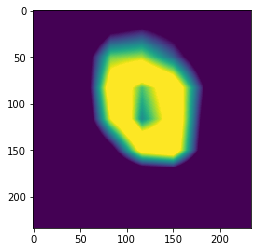

In [389]:
c_map = cmap[:,:,0]
plt.imshow(c_map)

In [374]:
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [384]:
c_map.shape

(234, 234)

In [385]:
params = fitgaussian(c_map)
fit = gaussian(*params)

In [387]:
params

array([328.47750921,  98.82767264, 121.61454184,  40.99674148,
        34.12454537])

## Computing the gaussian fit for Grad-CAM
Gradient-weighted Class Activation Mapping (Grad-CAM)

In [393]:
train_ds2 = ChestXrayDataSet(train_df, transform=False)
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=False, num_workers=1)

In [394]:
x, y = next(iter(train_dl2))

In [395]:
x.shape

torch.Size([16, 3, 234, 234])

In [403]:
def get_class_act_map(model, x, y):
    target_layer = "densenet121.features.denseblock4.denselayer16.conv2"
    gcam = GradCAM(model=model)
    gcam.forward(x)
    probs, ids = gcam.forward(x)
    gcam.backward(y)
    regions = gcam.generate(target_layer=target_layer)
    return regions.cpu().numpy()

In [404]:
regions = get_class_act_map(model, x.float().cuda(), y.float().cuda())

RuntimeError: CUDA out of memory. Tried to allocate 6.62 MiB (GPU 0; 10.92 GiB total capacity; 9.77 GiB already allocated; 1.50 MiB free; 309.10 MiB cached)

In [401]:
regions.shape

torch.Size([16, 1, 234, 234])

In [402]:
params = [fitgaussian(regions[i,0,:,:]) for i in range(regions.shape[0])]

TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray